# Data Drift Detection - Model Independent Methods

Verify the data drifts in the given dataset.

Different than Concept Drifts, Data Drifts merely refer to the incoming data under evaluation. Given a Drift Detector and a training period, the detector analysed the entire data outside the training period (i.e., the test set) and records the drifts for each given feature.

On the other hand, Concept Drifts refers to drifts into the evaluation model/classifier.

In [1]:
%reload_ext autoreload
%autoreload 2
import threadpoolctl
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from river import drift
from sklearn.model_selection import train_test_split
from intellect.dataset import Dataset
from intellect.distance import get_data_drifts
from intellect.io import create_dir, dump, load
from intellect.inspect import set_seed
from IPython import get_ipython
import os

#threadpoolctl.threadpool_limits(limits=2);
mpl.rcParams['figure.dpi']= 70

Define parameters and detectors to be tested.

In [5]:
# Parameters

LABEL = "Labelb"
TRAIN_SIZE = 0.1
DATASET="../../datasets/CICIDS2017-drifts/dataset.csv"

DETECTORS_TO_TEST = (drift.ADWIN(), drift.PageHinkley(), drift.binary.DDM(), drift.binary.HDDM_W(), drift.binary.HDDM_A(), drift.KSWIN())

In [ ]:
ip = get_ipython()
path = None
if '__vsc_ipynb_file__' in ip.user_ns:
    path = ip.user_ns['__vsc_ipynb_file__']

OUTPUT_DIR = os.path.basename(path).split(".")[0] + "_output/"

In [3]:
create_dir(OUTPUT_DIR)

Load the dataset and normalize data.

In [4]:
def load_ds():
    set_seed()
    df = pd.read_csv(DATASET, index_col=None)
    label = df.pop(LABEL)
    X_normalized = df.apply(
        lambda x: (x - x.min()) / (x.max() - x.min()))

    X_train_normalized, X_test_normalized = train_test_split(X_normalized, train_size = TRAIN_SIZE, shuffle=False)
    return Dataset(data=X_train_normalized, label=label, label_type=label, shuffle=False), Dataset(data=X_test_normalized, label=label, label_type=label, shuffle=False)

train_ds, test_ds = load_ds()

Test all the defined detectors.

In [6]:
for d in DETECTORS_TO_TEST:
    print(f"Testing {d.__class__.__name__}")
    x = get_data_drifts(train_ds, test_ds, detector=d)
    dump(x, OUTPUT_DIR + f"{d.__class__.__name__}.json")

Testing ADWIN
Testing PageHinkley
Testing DDM
Testing HDDM_W
Testing HDDM_A
Testing KSWIN


Finally, plot the results.

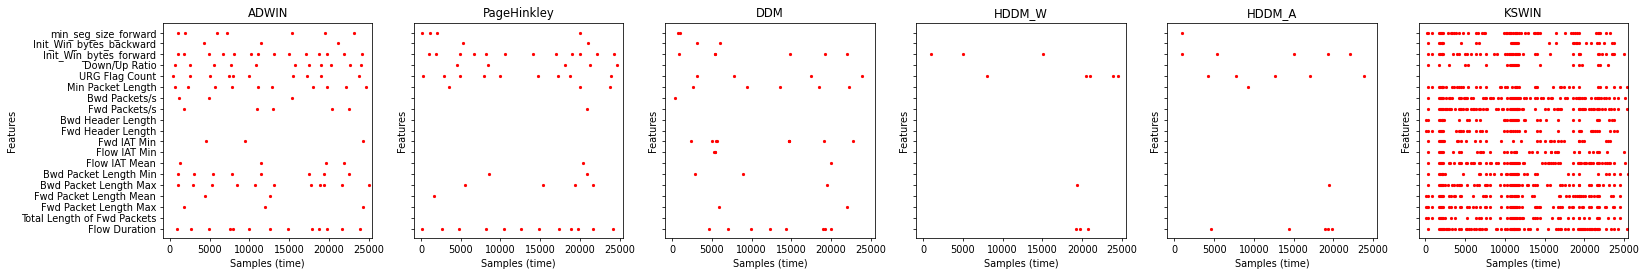

In [7]:
f, axes = plt.subplots(nrows=1, ncols=len(DETECTORS_TO_TEST), figsize=(27, 4), sharey=True, sharex=True)
for i, k in enumerate(DETECTORS_TO_TEST):
   v = load(OUTPUT_DIR + f"{k.__class__.__name__}.json")
   ax = axes[i]
   for ii, vv in enumerate(test_ds.X.columns, 1):
      if vv not in v:
         continue
      ax.scatter(x=v[vv], y=[ii for _ in range(len(v[vv]))], c="r", s=5)
   ax.set_yticks(range(1, 1 + test_ds.n_features))
   ax.set_xlim(right=test_ds.n_samples)
   ax.set_yticklabels(test_ds.X.columns.values)
   ax.set_xlabel("Samples (time)")
   ax.set_ylabel("Features")
   ax.set_title(k)
plt.show()
f.savefig(OUTPUT_DIR + "drifts.pdf")

We notice that these detectors are significantly different from each other. *ADWIN*, the most common and used, reports many data drifts for almost every feature. On the other hand, algorithms such as *HDDM_W* register only few data drifts for only few features.